In [1]:
import datetime
start = datetime.datetime.now()
start

datetime.datetime(2021, 2, 26, 16, 18, 5, 490630)

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras import optimizers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers import TimeDistributed
from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.


In [3]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\vsridha4\Desktop\RA\New_Algorithm


In [4]:
# -*- coding: utf-8 -*-
import pandas as pd
load = pd.read_csv(r'C:\Users\vsridha4\Desktop\RA\NEW\dataset_train_4_0to200.csv')

In [5]:
load.head

<bound method NDFrame.head of       Delivery Date  Delivery Hour Repeated Hour Flag Settlement Point Name  \
0          1/1/2015              1                  N            LZ_HOUSTON   
1          1/1/2015              2                  N            LZ_HOUSTON   
2          1/1/2015              3                  N            LZ_HOUSTON   
3          1/1/2015              4                  N            LZ_HOUSTON   
4          1/1/2015              5                  N            LZ_HOUSTON   
...             ...            ...                ...                   ...   
34633    12/31/2018             20                  N            LZ_HOUSTON   
34634    12/31/2018             21                  N            LZ_HOUSTON   
34635    12/31/2018             22                  N            LZ_HOUSTON   
34636    12/31/2018             23                  N            LZ_HOUSTON   
34637    12/31/2018             24                  N            LZ_HOUSTON   

      Settlement Poin

In [6]:
load.dtypes

import datetime
load['year'] = pd.DatetimeIndex(load['Delivery Date']).year
load['day'] = pd.DatetimeIndex(load['Delivery Date']).day# Extracting Day from "Delivery Date"
load['month'] = pd.DatetimeIndex(load['Delivery Date']).month   # Extracting Month from "Delivery Date"


a = load['Delivery Date']
a= pd.to_datetime(a)

load['dayofweek'] = a.dt.dayofweek
load['dayofweek']


0        3
1        3
2        3
3        3
4        3
        ..
34633    0
34634    0
34635    0
34636    0
34637    0
Name: dayofweek, Length: 34638, dtype: int64

In [7]:
load = load.set_index(['Delivery Date']) 
load = load.drop(columns=['year','day','Settlement Point Name','Settlement Point Type'], axis=1)  
# Re-arranging Columns
load = load[['dayofweek','month','Delivery Hour','Temperature in F','Load in Houston', 'Settlement Point Price']]
load.head()

,dayofweek,month,Delivery Hour,Temperature in F,Load in Houston,Settlement Point Price
Delivery Date,,,,,,
1/1/2015,3,1,1,44,9844.20,22.47
1/1/2015,3,1,2,44,9653.46,22.31
1/1/2015,3,1,3,44,9502.30,22.20
1/1/2015,3,1,4,44,9474.48,22.13
1/1/2015,3,1,5,44,9554.37,22.16


In [8]:
# Replacing 'N' and 'Y' with '0' and '1' respectively in column "Repeated Hour Flag"
#load = load.rename(columns={"Repeated Hour Flag": "Flag"})
#flag = {'N': 0,'Y': 1}  # dictionary
#load.Flag = [flag[item] for item in load.Flag]
#load.head()


In [9]:
# Replacing 'Weekday' and 'Weekend' with '0' and '1' respectively in column "DayStatus"
#daystatus = {'Weekday': 0,'Weekend': 1, 'Public Holiday': 2}  # dictionary
#load.DayStatus = [daystatus[item] for item in load.DayStatus]
#load.head()


In [10]:
# Removing "," from columns "Load in Houston" , "Ercot Load" and "Settlement Point Price"
load['Load in Houston'] = load['Load in Houston'].astype(str).str.replace(r',', '')
#load['Ercot Load'] = load['Ercot Load'].astype(str).str.replace(r',', '')
load['Settlement Point Price'] = load['Settlement Point Price'].astype(str).str.replace(r',', '')
load.head()

,dayofweek,month,Delivery Hour,Temperature in F,Load in Houston,Settlement Point Price
Delivery Date,,,,,,
1/1/2015,3,1,1,44,9844.2,22.47
1/1/2015,3,1,2,44,9653.46,22.31
1/1/2015,3,1,3,44,9502.3,22.2
1/1/2015,3,1,4,44,9474.48,22.13
1/1/2015,3,1,5,44,9554.37,22.16


In [11]:
load['Settlement Point Price'] = load['Settlement Point Price'].astype(float)
load['Temperature in F'] = load['Temperature in F'].astype(float)
load['Load in Houston'] = load['Load in Houston'].astype(float)
#load['Ercot Load'] = load['Ercot Load'].astype(float)
load['Settlement Point Price'] = round(load['Settlement Point Price'],2)
load.dtypes
#dataset = load.values

dayofweek                   int64
month                       int64
Delivery Hour               int64
Temperature in F          float64
Load in Houston           float64
Settlement Point Price    float64
dtype: object

In [12]:
past_hours = 2
n_steps = past_hours
next_hours = 2
next_steps = next_hours


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([("1",OneHotEncoder(sparse=False),make_column_selector(pattern = 'month')),
                             ("2",OneHotEncoder(sparse=False),make_column_selector(pattern = 'dayofweek')),
                             ("3",OneHotEncoder(sparse=False),make_column_selector(pattern = 'Delivery Hour')),
                             #("4",OneHotEncoder(sparse=False),make_column_selector(pattern = 'Delivery Interval')),
                             #("6",OneHotEncoder(sparse=False),make_column_selector(pattern = 'DayStatus')),
                             ("7",StandardScaler(copy=True), make_column_selector(pattern = 'Temperature in F')),
                             ("8",StandardScaler(copy=True), make_column_selector(pattern = 'Load in Houston')),
                             #("9",StandardScaler(copy=True), make_column_selector(pattern = 'Ercot Load')),
                             #("10",StandardScaler(copy=True),make_column_selector(pattern = 'Rise')),
                             ("y",QuantileTransformer(copy=True), make_column_selector(pattern = 'Settlement Point Price'))])
     

In [14]:
import numpy
dataset=load.values
#numpy.around(dataset, decimals=2, out=None)


In [15]:
normed_data = ct.fit_transform(load)
print(normed_data.shape)

(34638, 46)


In [16]:
normed_data = pd.DataFrame(normed_data)
dataset = normed_data.values

In [17]:
dataset=numpy.around(dataset, decimals=5, out=None)
dataset

array([[ 1.     ,  0.     ,  0.     , ..., -1.74483, -0.75033,  0.63213],
       [ 1.     ,  0.     ,  0.     , ..., -1.74483, -0.82378,  0.62513],
       [ 1.     ,  0.     ,  0.     , ..., -1.74483, -0.88198,  0.62012],
       ...,
       [ 0.     ,  0.     ,  0.     , ..., -0.98578, -0.5402 ,  0.12346],
       [ 0.     ,  0.     ,  0.     , ..., -0.98578, -0.62114,  0.13914],
       [ 0.     ,  0.     ,  0.     , ..., -0.98578, -0.68715,  0.0996 ]])

In [18]:
dataset.shape

(34638, 46)

In [19]:
series_reshaped =  np.array([dataset[i:i + (n_steps+next_steps)].copy() for i in range(len(dataset) - (n_steps+next_steps))])
series_reshaped[0]

array([[ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         0.     ,  1.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     , -1.74483, -0.75033,  0.63213],
       [ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  1.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,

In [20]:
series_reshaped.shape

(34634, 4, 46)

In [21]:
a = series_reshaped.shape[0]
b = int(0.9*a)
c = int(a-b)
d = int(c/2)

In [22]:
X_train = series_reshaped[:b, :n_steps]
X_val = series_reshaped[b:, :n_steps]

print(X_train.shape, X_val.shape)

(31170, 2, 46) (3464, 2, 46)


In [23]:
Y = np.empty((series_reshaped.shape[0], next_steps))
Y.shape

(34634, 2)

In [24]:
Y = np.empty((series_reshaped.shape[0], next_steps))
for step_ahead in range(0, next_steps):
    Y[..., step_ahead] = series_reshaped[..., (step_ahead+n_steps-next_steps+1), (X_train.shape[2]-1)]


In [25]:
Y_train = Y[:b]
Y_val = Y[b:]

In [26]:
print(Y_train.shape, Y_val.shape)

(31170, 2) (3464, 2)


In [27]:
X_train[0]

array([[ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         0.     ,  1.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     , -1.74483, -0.75033,  0.63213],
       [ 1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  1.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,

In [28]:
Y_train[0]

array([0.62513, 0.62012])

In [29]:

model = Sequential([
    #Conv1D(filters=32, kernel_size=1,strides=1, padding="valid", activation="relu", input_shape=(X_train.shape[1],X_train.shape[2])),
    #Conv1D(filters=64, kernel_size=1, strides=1, padding="causal", activation="relu"),
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Flatten(),
    #Dense(256, activation = "relu"),
    Dense(128, activation="relu"),
    #Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.1),
    Dense(32, activation="relu"),
    Dropout(0.1),
    Dense(next_steps)
])

In [30]:
from tensorflow import keras
lr_schedule = keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                decay_steps=1000000,
                                                decay_rate=0.98,
                                                  staircase=False)


In [31]:
from tensorflow import keras
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=1e-6)

In [32]:
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 128)            89600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 256)            394240    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

In [34]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [35]:
example_batch= X_val[0:10]
example_batch.shape

(10, 2, 46)

In [36]:
example_result = model.predict(example_batch)
example_result.shape

(10, 2)

In [37]:
example_result

array([[-0.00727869, -0.01967878],
       [-0.00530302, -0.01423122],
       [-0.00547508, -0.01496799],
       [-0.00457935, -0.01528685],
       [-0.00414878, -0.00992809],
       [-0.00188682, -0.00930897],
       [-0.00222706, -0.00835952],
       [-0.00397843, -0.0053873 ],
       [-0.00094401, -0.00154083],
       [-0.00116074, -0.00529872]], dtype=float32)

In [38]:
len(example_result)

10

In [39]:
last_list=[]

for i in range (0, len(example_result)):
  last_list.append((example_result[i][0]))

last_list

[-0.0072786896,
 -0.005303021,
 -0.005475083,
 -0.004579354,
 -0.00414878,
 -0.0018868224,
 -0.0022270586,
 -0.003978426,
 -0.00094401056,
 -0.00116074]

In [40]:
len(last_list)

10

In [41]:
import datetime
print(datetime.datetime.now())

2021-02-26 16:18:17.590216


In [42]:
EPOCHS = 2000

history = model.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_data = (X_val, Y_val), shuffle=False, verbose=1, 
    callbacks=[early_stop])

Train on 31170 samples, validate on 3464 samples
Epoch 1/2000
31170/31170 [==============================] - 9s 291us/step - loss: 0.0282 - mae: 0.1185 - mse: 0.0282 - val_loss: 0.0172 - val_mae: 0.1040 - val_mse: 0.0172
Epoch 2/2000
31170/31170 [==============================] - 9s 277us/step - loss: 0.0118 - mae: 0.0774 - mse: 0.0118 - val_loss: 0.0071 - val_mae: 0.0593 - val_mse: 0.0071
Epoch 3/2000
31170/31170 [==============================] - 9s 276us/step - loss: 0.0087 - mae: 0.0651 - mse: 0.0087 - val_loss: 0.0057 - val_mae: 0.0545 - val_mse: 0.0057
Epoch 4/2000
31170/31170 [==============================] - 9s 276us/step - loss: 0.0075 - mae: 0.0598 - mse: 0.0075 - val_loss: 0.0045 - val_mae: 0.0437 - val_mse: 0.0045
Epoch 5/2000
31170/31170 [==============================] - 9s 275us/step - loss: 0.0068 - mae: 0.0571 - mse: 0.0068 - val_loss: 0.0070 - val_mae: 0.0623 - val_mse: 0.0070
Epoch 6/2000
31170/31170 [==============================] - 9s 275us/step - loss: 0.0064 - 

In [43]:
import datetime
b=datetime.datetime.now()
b

datetime.datetime(2021, 2, 26, 16, 22, 2, 237759)

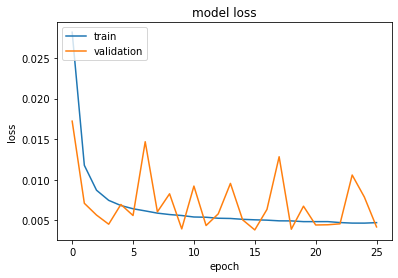

In [44]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [45]:
test_predictions = model.predict(X_val)
op_list= []
for i in range (0, len(test_predictions)):
  op_list.append((test_predictions[i][1]))
len(op_list)

3464

In [46]:
op_list

[0.79425865,
 0.66333437,
 0.5316813,
 0.40109926,
 0.28700405,
 0.27204293,
 0.24765861,
 0.27369708,
 0.2795167,
 0.3755942,
 0.420487,
 0.5165117,
 0.62649715,
 0.66974556,
 0.804562,
 0.89740753,
 0.9396931,
 0.965147,
 0.93445224,
 0.867453,
 0.849686,
 0.82963383,
 0.85606116,
 0.8945583,
 0.74757063,
 0.59797156,
 0.49321225,
 0.42884308,
 0.3331589,
 0.30700624,
 0.3346089,
 0.30625528,
 0.41883123,
 0.46886277,
 0.49581012,
 0.5302498,
 0.75602406,
 0.8833064,
 0.9114005,
 0.95115715,
 0.9902595,
 0.99258643,
 0.99203295,
 0.9350028,
 0.89252114,
 0.8856152,
 0.90776306,
 0.7966994,
 0.6991181,
 0.61013854,
 0.55661535,
 0.48411143,
 0.4708346,
 0.49898648,
 0.5144842,
 0.5016657,
 0.5795674,
 0.5874191,
 0.69812363,
 0.84894395,
 0.7923372,
 0.84048724,
 0.8795017,
 0.9003898,
 0.9027427,
 0.89870983,
 0.8941568,
 0.87003493,
 0.8474618,
 0.81053627,
 0.81921947,
 0.740119,
 0.6882597,
 0.5630834,
 0.6169353,
 0.6577747,
 0.5706163,
 0.5707798,
 0.5974614,
 0.562784,
 0.53747

In [47]:
test_labels = pd.DataFrame({'actual':(Y_val[:,1])})
#test_labels.rename(columns = {(Y_test.shape[1]):'actual'}, inplace = True)
#test_labels['actual']
test_labels['actual']

0       0.81502
1       0.67267
2       0.46096
3       0.33333
4       0.28428
         ...   
3459    0.62713
3460    0.60561
3461    0.57658
3462    0.30244
3463    0.12346
Name: actual, Length: 3464, dtype: float64

In [48]:
np.reshape(test_labels, (-1,1))
test_labels.shape

(3464, 1)

In [49]:
test_labels['actual']=ct.named_transformers_['y'].inverse_transform(test_labels)
test_labels['actual']

0       28.210249
1       23.379947
2       19.990000
3       18.819967
4       18.309957
          ...    
3459    22.350057
3460    21.930088
3461    21.450068
3462    18.500037
3463    16.040096
Name: actual, Length: 3464, dtype: float64

In [50]:
predictions=pd.DataFrame({'predict':op_list})
predictions['predict'] = ct.named_transformers_['y'].inverse_transform(predictions)

In [51]:
predictions['predict']

0       27.286624
1       23.155557
2       20.831496
3       19.436982
4       18.337170
          ...    
3459    23.052143
3460    23.489572
3461    21.105778
3462    21.271378
3463    17.828574
Name: predict, Length: 3464, dtype: float64

In [52]:
test_labels['actual']

0       28.210249
1       23.379947
2       19.990000
3       18.819967
4       18.309957
          ...    
3459    22.350057
3460    21.930088
3461    21.450068
3462    18.500037
3463    16.040096
Name: actual, Length: 3464, dtype: float64

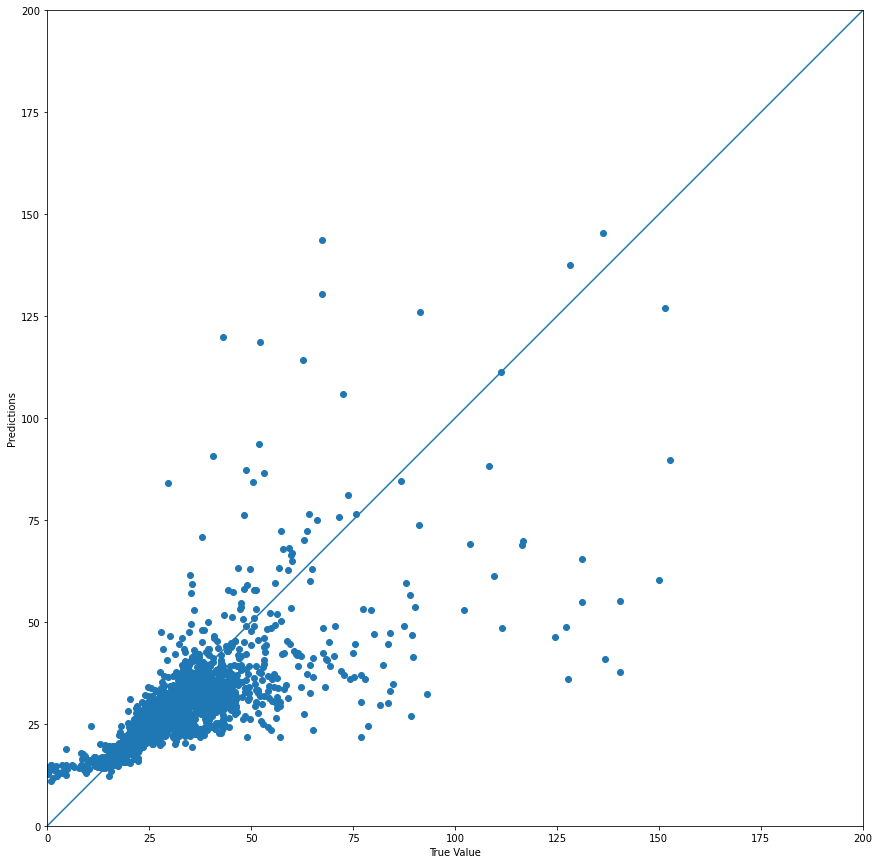

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['actual'], predictions)
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [0, 200]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

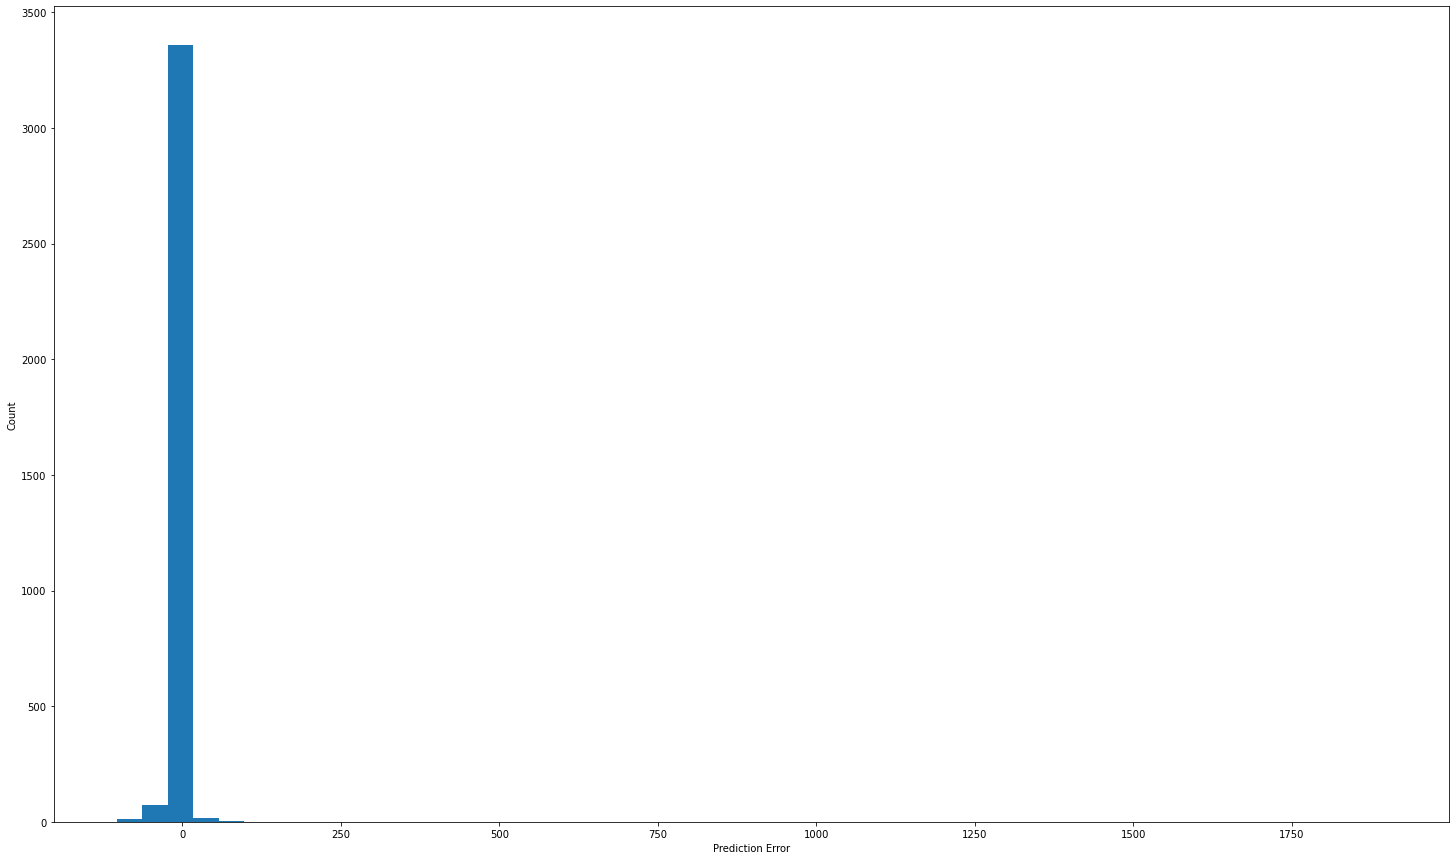

In [54]:
error = round(predictions['predict'],2) - round(test_labels['actual'],2)
plt.figure(figsize=(25,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")


In [55]:
print(predictions[0:10], test_labels['actual'][0:10], error[0:10])

     predict
0  27.286624
1  23.155557
2  20.831496
3  19.436982
4  18.337170
5  18.177709
6  17.894110
7  18.190000
8  18.252372
9  19.202186 0    28.210249
1    23.379947
2    19.990000
3    18.819967
4    18.309957
5    17.839968
6    17.729968
7    17.589966
8    18.220054
9    19.179966
Name: actual, dtype: float64 0   -0.92
1   -0.22
2    0.84
3    0.62
4    0.03
5    0.34
6    0.16
7    0.60
8    0.03
9    0.02
dtype: float64


In [56]:
i=0
count=0
for i in range(len(error)):
    if ((error[i])>5) or ((error[i]<-5)):
        count=count+1
print(count)

697


In [57]:
a = len(predictions) - count
a
accuracy = (a/len(predictions))*100
print('accuracy:', accuracy)

accuracy: 79.87875288683603


In [58]:
from statistics import mean, stdev
print('Mean of error in test data:', mean(error))
print('Standard deviation of error in test data:', stdev(error))

Mean of error in test data: 0.11443418013856801
Standard deviation of error in test data: 58.32881834942925


In [59]:
from statistics import mean, stdev
print('Mean of test data:', mean(test_labels['actual']))
print('Standard deviation of test data:', stdev(test_labels['actual']))

Mean of test data: 27.92255865196976
Standard deviation of test data: 13.837448141380454


In [60]:
import datetime
stop =datetime.datetime.now()
stop

datetime.datetime(2021, 2, 26, 16, 22, 3, 871387)

In [61]:
print(stop-start)

0:03:58.380757


In [62]:
for j in range(1,11):
    i=0
    count=0
    for i in range(len(error)):
        if ((error[i])>j) or ((error[i]<-j)):
            count=count+1
    a = len(predictions) - count
    accuracy = (a/len(predictions))*100
    print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)

accuracy: with threshold of 1  is 43.65
accuracy: with threshold of 2  is 60.48
accuracy: with threshold of 3  is 69.92
accuracy: with threshold of 4  is 76.01
accuracy: with threshold of 5  is 79.88
accuracy: with threshold of 6  is 83.29
accuracy: with threshold of 7  is 86.00
accuracy: with threshold of 8  is 87.44
accuracy: with threshold of 9  is 89.03
accuracy: with threshold of 10  is 90.30


In [63]:
from keras.models import save_model
save_model(model,r'C:\Users\vsridha4\Desktop\RA\NEW\final_lstm_hour_ahead.h5',include_optimizer=True)

C:\Users\vsridha4\.conda\envs\test\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
